In [8]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4),
        # ▼ ここで Flag qubit 用の座標を適当に追加 (例)
        25: (1, 3),  # ancilla=12用 Flag
        26: (3, 5),  # ancilla=14用 Flag
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits , noise_prob=0):
    for qubit in data_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=0):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0, color_code = False):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 2量子ビットの DEPOLARIZE2 を入れる
                    if ancilla not in (-12, -14):
                        circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    # Zスタビライザ時は今まで通り必ずエラーを入れる
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla が 12, 13 の場合のみエラーをスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR

        circuit.append("MR", [ancilla])

        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                    ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def append_syndrome_measurement_with_flag_for_12_14(
    circuit,
    stabilizer, 
    is_X_stabilizer=False, 
    add_detector=False, 
    interval=False, 
    noise_prob=0, 
    color_code=False,
    # どの ancilla に対してどの flag qubit を使うかを dict で渡す (例: {12:25, 14:26})
    flag_map={12: 25, 14: 26},
):
    """
    元の append_syndrome_measurement(...) と同じ流れ:
      1) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      2) CNOT ループ (for i in range(max_iterations)) → TICK
      3) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      4) MR(ancilla) + X_ERROR/DEPOLARIZE1 → TICK
      5) add_detector が True なら DETECTOR を追加

    ただし ancilla=12,14 の場合のみ、2個目と3個目のCNOTをフラグ CNOT で挟むように配置する。
    コントロールは ancilla、ターゲットが flag qubit。
    """

    # =======================================
    # 1) (Xスタビライザなら) ancilla に H をかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # ancilla が -12, -14 以外なら DEPOLARIZE1
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 2) シンドローム測定の CNOT をまとめて行う部分
    #    ancilla=12,14 には特別にフラグCNOTを挿入
    # =======================================
    # まず、各 ancilla について「どのターゲットにいつ CNOT をかけるか」のリストを作る
    target_map = {}
    for ancilla, dq_tuple in stabilizer.items():
        dq_list = list(dq_tuple)

        if ancilla in flag_map:
            # フラグを挟みたい場合 (ancilla=12 or 14 を想定)
            # ここでは最大4つのデータキュビットを想定し、
            #  i=0: dq[0],  i=1: flag,   i=2: dq[1],
            #  i=3: dq[2], i=4: flag,   i=5: dq[3]
            # のように配置している
            while len(dq_list) < 4:
                dq_list.append(None)  # データが足りない場合は埋める

            target_map[ancilla] = [
                dq_list[0],    # i=0
                "FLAG",        # i=1
                dq_list[1],    # i=2
                dq_list[2],    # i=3
                "FLAG",        # i=4
                dq_list[3],    # i=5
            ]
        else:
            # それ以外の ancilla は通常どおり data_qubits を順番に結ぶ
            target_map[ancilla] = dq_list

    # ループ回数は全 ancilla のターゲットリスト長の最大値
    max_iterations = max(len(t_list) for t_list in target_map.values())

    # CNOT をまとめて挿入
    for i in range(max_iterations):
        for ancilla, t_list in target_map.items():
            if i < len(t_list):
                target = t_list[i]
                if target is None:
                    # 空なら何もしない
                    continue

                if target == "FLAG":
                    # フラグ qubit との CNOT
                    # (コントロール=ancilla, ターゲット=flag)
                    flag_qubit = flag_map.get(ancilla, None)
                    if flag_qubit is None:
                        continue  # あるいはエラーを投げてもよい

                    circuit.append("CX", [ancilla, flag_qubit])

                    # エラー挿入
                    if is_X_stabilizer:
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)
                    else:
                        # Zスタビライザなら常に 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)

                else:
                    # 通常のデータ qubit との CNOT
                    if is_X_stabilizer:
                        circuit.append("CX", [ancilla, target])
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, target], noise_prob)
                    else:
                        circuit.append("CX", [target, ancilla])
                        # Zスタビライザでは必ず 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [target, ancilla], noise_prob)

        circuit.append("TICK")

    # =======================================
    # 3) (Xスタビライザなら) ancilla にHをかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 4) MR(ancilla) & X_ERROR/DEPOLARIZE1 の部分
    # =======================================
    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla in (-12, -14) は X_ERROR をスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
        circuit.append("MR", [ancilla])
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)

        # フラグ qubit も測りたい場合はここで測定
        if ancilla in flag_map:
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("MR", [flag_map[ancilla]])
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("DEPOLARIZE1", [flag_map[ancilla]], noise_prob)

    circuit.append("TICK")

    # =======================================
    # 5) add_detector / DETECTORの追加 (必要があれば)
    # =======================================
    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [
                    stim.target_rec(-len(stabilizer) + idx),
                ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def main(d, p):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (2, 3, 5, 6), 13: (2, 8, 1, 3, 4, 10), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    # step_2={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits, noise_prob=p)
    reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=p)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=False, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True, noise_prob=0, color_code=True)

    append_syndrome_measurement_with_flag_for_12_14(circuit,step_1, is_X_stabilizer=True, noise_prob=p, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-13), stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-12)])
    circuit.append("DETECTOR", [stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-4)])

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-17)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5)])

    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-20)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])

    for i in range(0):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p) 
    
    circuit.append("M", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-7),], 0)
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2),
                                stim.target_rec(-20), stim.target_rec(-19),stim.target_rec(-18),])
    circuit.append("DETECTOR", [stim.target_rec(-7), stim.target_rec(-6), 
                                stim.target_rec(-21)])
    circuit.append("DETECTOR", [stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-6), stim.target_rec(-5), 
                                stim.target_rec(-23)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1),
                                stim.target_rec(-22)])


    return circuit


circuit = main(3, 0.01)
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [9]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4),
        # ▼ ここで Flag qubit 用の座標を適当に追加 (例)
        25: (1, 3),  # ancilla=12用 Flag
        26: (3, 5),  # ancilla=14用 Flag
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits , noise_prob=0):
    for qubit in data_qubits:
        if qubit in [8, 9, 10, 11]:
            circuit.append("R", [qubit])
            circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R
        else:
            circuit.append("RX", [qubit])
            circuit.append("Z_ERROR", [qubit], noise_prob)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=0):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0, color_code = False):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 2量子ビットの DEPOLARIZE2 を入れる
                    if ancilla not in (-12, -14):
                        circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    # Zスタビライザ時は今まで通り必ずエラーを入れる
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla が 12, 13 の場合のみエラーをスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR

        circuit.append("MR", [ancilla])

        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                    ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-3*len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def append_syndrome_measurement_with_flag_for_12_14(
    circuit,
    stabilizer, 
    is_X_stabilizer=False, 
    add_detector=False, 
    interval=False, 
    noise_prob=0, 
    color_code=False,
    # どの ancilla に対してどの flag qubit を使うかを dict で渡す (例: {12:25, 14:26})
    flag_map={12: 25, 14: 26},
):
    """
    元の append_syndrome_measurement(...) と同じ流れ:
      1) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      2) CNOT ループ (for i in range(max_iterations)) → TICK
      3) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      4) MR(ancilla) + X_ERROR/DEPOLARIZE1 → TICK
      5) add_detector が True なら DETECTOR を追加

    ただし ancilla=12,14 の場合のみ、2個目と3個目のCNOTをフラグ CNOT で挟むように配置する。
    コントロールは ancilla、ターゲットが flag qubit。
    """

    # =======================================
    # 1) (Xスタビライザなら) ancilla に H をかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # ancilla が -12, -14 以外なら DEPOLARIZE1
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 2) シンドローム測定の CNOT をまとめて行う部分
    #    ancilla=12,14 には特別にフラグCNOTを挿入
    # =======================================
    # まず、各 ancilla について「どのターゲットにいつ CNOT をかけるか」のリストを作る
    target_map = {}
    for ancilla, dq_tuple in stabilizer.items():
        dq_list = list(dq_tuple)

        if ancilla in flag_map:
            # フラグを挟みたい場合 (ancilla=12 or 14 を想定)
            # ここでは最大4つのデータキュビットを想定し、
            #  i=0: dq[0],  i=1: flag,   i=2: dq[1],
            #  i=3: dq[2], i=4: flag,   i=5: dq[3]
            # のように配置している
            while len(dq_list) < 4:
                dq_list.append(None)  # データが足りない場合は埋める

            target_map[ancilla] = [
                dq_list[0],    # i=0
                "FLAG",        # i=1
                dq_list[1],    # i=2
                dq_list[2],    # i=3
                "FLAG",        # i=4
                dq_list[3],    # i=5
            ]
        else:
            # それ以外の ancilla は通常どおり data_qubits を順番に結ぶ
            target_map[ancilla] = dq_list

    # ループ回数は全 ancilla のターゲットリスト長の最大値
    max_iterations = max(len(t_list) for t_list in target_map.values())

    # CNOT をまとめて挿入
    for i in range(max_iterations):
        for ancilla, t_list in target_map.items():
            if i < len(t_list):
                target = t_list[i]
                if target is None:
                    # 空なら何もしない
                    continue

                if target == "FLAG":
                    # フラグ qubit との CNOT
                    # (コントロール=ancilla, ターゲット=flag)
                    flag_qubit = flag_map.get(ancilla, None)
                    if flag_qubit is None:
                        continue  # あるいはエラーを投げてもよい

                    circuit.append("CX", [ancilla, flag_qubit])

                    # エラー挿入
                    if is_X_stabilizer:
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)
                    else:
                        # Zスタビライザなら常に 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)

                else:
                    # 通常のデータ qubit との CNOT
                    if is_X_stabilizer:
                        circuit.append("CX", [ancilla, target])
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, target], noise_prob)
                    else:
                        circuit.append("CX", [target, ancilla])
                        # Zスタビライザでは必ず 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [target, ancilla], noise_prob)

        circuit.append("TICK")

    # =======================================
    # 3) (Xスタビライザなら) ancilla にHをかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 4) MR(ancilla) & X_ERROR/DEPOLARIZE1 の部分
    # =======================================
    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla in (-12, -14) は X_ERROR をスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
        circuit.append("MR", [ancilla])
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)

        # フラグ qubit も測りたい場合はここで測定
        if ancilla in flag_map:
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("MR", [flag_map[ancilla]])
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("DEPOLARIZE1", [flag_map[ancilla]], noise_prob)

    circuit.append("TICK")

    # =======================================
    # 5) add_detector / DETECTORの追加 (必要があれば)
    # =======================================
    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [
                    stim.target_rec(-len(stabilizer) + idx),
                ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def main(d, p):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (2, 3, 5, 6), 13: (2, 8, 1, 3, 4, 10), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    # step_2={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits, noise_prob=p)
    reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=p)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=False, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=False, noise_prob=0, color_code=True)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=False, noise_prob=0)
    

    append_syndrome_measurement_with_flag_for_12_14(circuit,step_1, is_X_stabilizer=True, noise_prob=p, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-13), stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-12)])
    circuit.append("DETECTOR", [stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-4)])

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=0)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-17)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5)])

    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=0)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-20)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])

    for i in range(0):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=0)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=0) 
    
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=0)
    
    circuit.append("MX", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 0)
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2),
                                stim.target_rec(-20), stim.target_rec(-19),stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6),
                                stim.target_rec(-23)])
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1), 
                                stim.target_rec(-22)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1),
                                stim.target_rec(-21)])


    return circuit


circuit = main(3, 0.01)
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [10]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4),
        # ▼ ここで Flag qubit 用の座標を適当に追加 (例)
        25: (1, 3),  # ancilla=12用 Flag
        26: (3, 5),  # ancilla=14用 Flag
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits , noise_prob=0):
    for qubit in data_qubits:
        if qubit in [8, 9, 10, 11]:
            circuit.append("R", [qubit])
            circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R
        else:
            circuit.append("RX", [qubit])
            circuit.append("Z_ERROR", [qubit], noise_prob)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=0):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        if not qubit in  [15]:
            circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0, color_code = False):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 2量子ビットの DEPOLARIZE2 を入れる
                    if ancilla not in (-12, -14):
                        circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    # Zスタビライザ時は今まで通り必ずエラーを入れる
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla が 12, 13 の場合のみエラーをスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR

        circuit.append("MR", [ancilla])

        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                    ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-3*len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def append_syndrome_measurement_with_flag_for_12_14(
    circuit,
    stabilizer, 
    is_X_stabilizer=False, 
    add_detector=False, 
    interval=False, 
    noise_prob=0, 
    color_code=False,
    # どの ancilla に対してどの flag qubit を使うかを dict で渡す (例: {12:25, 14:26})
    flag_map={12: 25, 14: 26},
):
    """
    元の append_syndrome_measurement(...) と同じ流れ:
      1) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      2) CNOT ループ (for i in range(max_iterations)) → TICK
      3) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      4) MR(ancilla) + X_ERROR/DEPOLARIZE1 → TICK
      5) add_detector が True なら DETECTOR を追加

    ただし ancilla=12,14 の場合のみ、2個目と3個目のCNOTをフラグ CNOT で挟むように配置する。
    コントロールは ancilla、ターゲットが flag qubit。
    """

    # =======================================
    # 1) (Xスタビライザなら) ancilla に H をかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # ancilla が -12, -14 以外なら DEPOLARIZE1
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 2) シンドローム測定の CNOT をまとめて行う部分
    #    ancilla=12,14 には特別にフラグCNOTを挿入
    # =======================================
    # まず、各 ancilla について「どのターゲットにいつ CNOT をかけるか」のリストを作る
    target_map = {}
    for ancilla, dq_tuple in stabilizer.items():
        dq_list = list(dq_tuple)

        if ancilla in flag_map:
            # フラグを挟みたい場合 (ancilla=12 or 14 を想定)
            # ここでは最大4つのデータキュビットを想定し、
            #  i=0: dq[0],  i=1: flag,   i=2: dq[1],
            #  i=3: dq[2], i=4: flag,   i=5: dq[3]
            # のように配置している
            while len(dq_list) < 4:
                dq_list.append(None)  # データが足りない場合は埋める

            target_map[ancilla] = [
                dq_list[0],    # i=0
                "FLAG",        # i=1
                dq_list[1],    # i=2
                dq_list[2],    # i=3
                "FLAG",        # i=4
                dq_list[3],    # i=5
            ]
        else:
            # それ以外の ancilla は通常どおり data_qubits を順番に結ぶ
            target_map[ancilla] = dq_list

    # ループ回数は全 ancilla のターゲットリスト長の最大値
    max_iterations = max(len(t_list) for t_list in target_map.values())

    # CNOT をまとめて挿入
    for i in range(max_iterations):
        for ancilla, t_list in target_map.items():
            if i < len(t_list):
                target = t_list[i]
                if target is None:
                    # 空なら何もしない
                    continue

                if target == "FLAG":
                    # フラグ qubit との CNOT
                    # (コントロール=ancilla, ターゲット=flag)
                    flag_qubit = flag_map.get(ancilla, None)
                    if flag_qubit is None:
                        continue  # あるいはエラーを投げてもよい

                    circuit.append("CX", [ancilla, flag_qubit])

                    # エラー挿入
                    if is_X_stabilizer:
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)
                    else:
                        # Zスタビライザなら常に 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)

                else:
                    # 通常のデータ qubit との CNOT
                    if is_X_stabilizer:
                        circuit.append("CX", [ancilla, target])
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, target], noise_prob)
                    else:
                        circuit.append("CX", [target, ancilla])
                        # Zスタビライザでは必ず 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [target, ancilla], noise_prob)

        circuit.append("TICK")

    # =======================================
    # 3) (Xスタビライザなら) ancilla にHをかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 4) MR(ancilla) & X_ERROR/DEPOLARIZE1 の部分
    # =======================================
    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla in (-12, -14) は X_ERROR をスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
        circuit.append("MR", [ancilla])
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)

        # フラグ qubit も測りたい場合はここで測定
        if ancilla in flag_map:
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("MR", [flag_map[ancilla]])
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("DEPOLARIZE1", [flag_map[ancilla]], noise_prob)

    circuit.append("TICK")

    # =======================================
    # 5) add_detector / DETECTORの追加 (必要があれば)
    # =======================================
    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [
                    stim.target_rec(-len(stabilizer) + idx),
                ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def main(d, p, n):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (2,5,3,6), 13: (2, 8, 1, 3, 4, 10), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    # step_2={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits, noise_prob=p)
    reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=p)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=False, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=True, noise_prob=0, color_code=True)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True, noise_prob=0)

    # circuit.append("X_ERROR", [15], 1)
    for g in n:
        if g in data_qubits:
            circuit.append("Z_ERROR", g, 1)
        else:
            circuit.append("X_ERROR", g, 1)


    append_syndrome_measurement_with_flag_for_12_14(circuit,step_1, is_X_stabilizer=True, noise_prob=0, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-13), stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-12)])
    circuit.append("DETECTOR", [stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-4)])

    
    

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-17)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-5)])



    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-20)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])

    for i in range(0):
        append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
        append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p) 
    
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    
    circuit.append("MX", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 0)
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2),
                                stim.target_rec(-20), stim.target_rec(-19),stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6),
                                stim.target_rec(-23)])
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1), 
                                stim.target_rec(-22)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1),
                                stim.target_rec(-21)])


    return circuit


circuit = main(3, 0, [12])
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [122]:
import stim

def initialize_circuit():
    return stim.Circuit()

def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 6), 15: (5, 4), 16: (5, 0),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (4, 1), 23: (2, 1), 24: (3, 4),
        # ▼ ここで Flag qubit 用の座標を適当に追加 (例)
        25: (1, 3),  # ancilla=12用 Flag
        26: (3, 5),  # ancilla=14用 Flag
    }

def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

def reset_data_qubits(circuit, data_qubits , noise_prob=0):
    for qubit in data_qubits:
        if qubit in [8, 9, 10, 11]:
            circuit.append("R", [qubit])
            circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R
        else:
            circuit.append("RX", [qubit])
            circuit.append("Z_ERROR", [qubit], noise_prob)  # Add X error after R

def reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=0):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])
        if not qubit in  [15]:
            circuit.append("X_ERROR", [qubit], noise_prob)  # Add X error after R

def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval=False, noise_prob=0, color_code = False):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)  # DEP1 after H
        circuit.append("TICK")

    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                    # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 2量子ビットの DEPOLARIZE2 を入れる
                    if ancilla not in (-12, -14):
                        circuit.append("DEPOLARIZE2", [ancilla, data_qubit], noise_prob)
                else:
                    circuit.append("CX", [data_qubit, ancilla])
                    # Zスタビライザ時は今まで通り必ずエラーを入れる
                    circuit.append("DEPOLARIZE2", [data_qubit, ancilla], noise_prob)
        circuit.append("TICK")

    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # Xスタビライザかつ ancilla が 12, 13 以外のときのみ 1量子ビットの DEPOLARIZE1 を入れる
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla が 12, 13 の場合のみエラーをスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error before MR

        circuit.append("MR", [ancilla])

        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)  # Add X error after MR
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
    circuit.append("TICK")

    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                    ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-3*len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def append_syndrome_measurement_with_flag_for_12_14(
    circuit,
    stabilizer, 
    is_X_stabilizer=False, 
    add_detector=False, 
    interval=False, 
    noise_prob=0, 
    color_code=False,
    # どの ancilla に対してどの flag qubit を使うかを dict で渡す (例: {12:25, 14:26})
    flag_map={12: 25, 14: 26},
):
    """
    元の append_syndrome_measurement(...) と同じ流れ:
      1) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      2) CNOT ループ (for i in range(max_iterations)) → TICK
      3) (Xスタビライザなら) ancilla に H → DEPOLARIZE1 → TICK
      4) MR(ancilla) + X_ERROR/DEPOLARIZE1 → TICK
      5) add_detector が True なら DETECTOR を追加

    ただし ancilla=12,14 の場合のみ、2個目と3個目のCNOTをフラグ CNOT で挟むように配置する。
    コントロールは ancilla、ターゲットが flag qubit。
    """

    # =======================================
    # 1) (Xスタビライザなら) ancilla に H をかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            # ancilla が -12, -14 以外なら DEPOLARIZE1
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 2) シンドローム測定の CNOT をまとめて行う部分
    #    ancilla=12,14 には特別にフラグCNOTを挿入
    # =======================================
    # まず、各 ancilla について「どのターゲットにいつ CNOT をかけるか」のリストを作る
    target_map = {}
    for ancilla, dq_tuple in stabilizer.items():
        dq_list = list(dq_tuple)

        if ancilla in flag_map:
            # フラグを挟みたい場合 (ancilla=12 or 14 を想定)
            # ここでは最大4つのデータキュビットを想定し、
            #  i=0: dq[0],  i=1: flag,   i=2: dq[1],
            #  i=3: dq[2], i=4: flag,   i=5: dq[3]
            # のように配置している
            while len(dq_list) < 4:
                dq_list.append(None)  # データが足りない場合は埋める

            target_map[ancilla] = [
                dq_list[0],    # i=0
                "FLAG",        # i=1
                dq_list[1],    # i=2
                dq_list[2],    # i=3
                "FLAG",        # i=4
                dq_list[3],    # i=5
            ]
        else:
            # それ以外の ancilla は通常どおり data_qubits を順番に結ぶ
            target_map[ancilla] = dq_list

    # ループ回数は全 ancilla のターゲットリスト長の最大値
    max_iterations = max(len(t_list) for t_list in target_map.values())

    # CNOT をまとめて挿入
    for i in range(max_iterations):
        for ancilla, t_list in target_map.items():
            if i < len(t_list):
                target = t_list[i]
                if target is None:
                    # 空なら何もしない
                    continue

                if target == "FLAG":
                    # フラグ qubit との CNOT
                    # (コントロール=ancilla, ターゲット=flag)
                    flag_qubit = flag_map.get(ancilla, None)
                    if flag_qubit is None:
                        continue  # あるいはエラーを投げてもよい

                    circuit.append("CX", [ancilla, flag_qubit])

                    # エラー挿入
                    if is_X_stabilizer:
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)
                    else:
                        # Zスタビライザなら常に 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [ancilla, flag_qubit], noise_prob)

                else:
                    # 通常のデータ qubit との CNOT
                    if is_X_stabilizer:
                        circuit.append("CX", [ancilla, target])
                        # ancilla not in (-12, -14) の場合のみ 2量子ビットエラー
                        if ancilla not in (-12, -14):
                            circuit.append("DEPOLARIZE2", [ancilla, target], noise_prob)
                    else:
                        circuit.append("CX", [target, ancilla])
                        # Zスタビライザでは必ず 2量子ビットエラー
                        circuit.append("DEPOLARIZE2", [target, ancilla], noise_prob)

        circuit.append("TICK")

    # =======================================
    # 3) (Xスタビライザなら) ancilla にHをかける部分
    # =======================================
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
            if ancilla not in (-12, -14):
                circuit.append("DEPOLARIZE1", [ancilla], noise_prob)
        circuit.append("TICK")

    # =======================================
    # 4) MR(ancilla) & X_ERROR/DEPOLARIZE1 の部分
    # =======================================
    for ancilla in stabilizer.keys():
        # Xスタビライザかつ ancilla in (-12, -14) は X_ERROR をスキップ
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
        circuit.append("MR", [ancilla])
        if not (is_X_stabilizer and ancilla in (-12, -14)):
            circuit.append("X_ERROR", [ancilla], noise_prob)
            circuit.append("DEPOLARIZE1", [ancilla], noise_prob)

        # フラグ qubit も測りたい場合はここで測定
        if ancilla in flag_map:
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("MR", [flag_map[ancilla]])
            circuit.append("X_ERROR", [flag_map[ancilla]], noise_prob)
            circuit.append("DEPOLARIZE1", [flag_map[ancilla]], noise_prob)

    circuit.append("TICK")

    # =======================================
    # 5) add_detector / DETECTORの追加 (必要があれば)
    # =======================================
    if add_detector:
        if color_code:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [
                    stim.target_rec(-len(stabilizer) + idx),
                ])
        else:
            if not interval:
                for idx, ancilla in enumerate(stabilizer.keys()):
                    circuit.append("DETECTOR", [
                        stim.target_rec(-len(stabilizer) + idx),
                        stim.target_rec(-len(stabilizer) + idx)
                    ])
            else:
                circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
                circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
                circuit.append("DETECTOR", [
                    stim.target_rec(-3), stim.target_rec(-1),
                    stim.target_rec(-2), stim.target_rec(-15),
                    stim.target_rec(-13), stim.target_rec(-14)
                ])
                circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])


def main(d, p, n):
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    color_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
    step_1={12: (2,5,3,6), 13: (2, 8, 1, 3, 4, 10), 14: (7, 4, 6, 3), 15: (7, 11, 4, 10), 22: (10, 8), 21: (11, 9)}
    step_2={12: (5, 6, 2, 3), 13: (3, 10, 1, 4, 8, 2), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (3, 6, 2, 5), 15: (7, 11, 4, 10), 21: (11, 9), 22: (10, 8), 23: (1, 2), 24: (4, 3)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits, noise_prob=p)
    reset_ancilla_qubits(circuit, ancilla_qubits, noise_prob=p)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=False, noise_prob=0)
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=True, noise_prob=0, color_code=True)
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True, noise_prob=0)

    # circuit.append("X_ERROR", [15], 1)
    
    for g in n:
        if g in data_qubits:
            circuit.append("Z_ERROR", g, 1)
        else:
            circuit.append("X_ERROR", g, 1)

    append_syndrome_measurement_with_flag_for_12_14(circuit, step_1, is_X_stabilizer=True, noise_prob=p, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-13), stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-12)])
    circuit.append("DETECTOR", [stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-4)])
    

    append_syndrome_measurement(circuit, step_2, noise_prob=p, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-13)])
    circuit.append("DETECTOR", [stim.target_rec(-1)])

    append_syndrome_measurement_with_flag_for_12_14(circuit,step_1, is_X_stabilizer=True, noise_prob=p, add_detector=False)
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-20)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-13)])
    circuit.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-14)])
    circuit.append("DETECTOR", [stim.target_rec(-7)])
    circuit.append("DETECTOR", [stim.target_rec(-4)])
    

    append_syndrome_measurement(circuit, floquet_Z, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1), stim.target_rec(-17)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-16)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])



    append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, noise_prob=p)
    circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-20)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-15)])
    circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-13)])

    # for i in range(0):
    #     append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    #     append_syndrome_measurement(circuit, floquet_X, is_X_stabilizer=True, add_detector=True, interval=True, noise_prob=p) 
    
    append_syndrome_measurement(circuit, floquet_Z, add_detector=True, interval=True, noise_prob=p)
    
    circuit.append("MX", data_qubits)
    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 0)
    circuit.append("DETECTOR", [stim.target_rec(-11), stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-8), stim.target_rec(-4), stim.target_rec(-2),
                                stim.target_rec(-20), stim.target_rec(-19),stim.target_rec(-18)])
    circuit.append("DETECTOR", [stim.target_rec(-10), stim.target_rec(-9), stim.target_rec(-7), stim.target_rec(-6),
                                stim.target_rec(-23)])
    circuit.append("DETECTOR", [stim.target_rec(-8), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1), 
                                stim.target_rec(-22)])
    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1),
                                stim.target_rec(-21)])


    return circuit


circuit = main(3, 0, [0,0])
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [118]:
import itertools

# 1から11までのリストを作成
numbers = list(range(1, 27))

# すべての2つの組み合わせを生成し、各組み合わせをリストに変換
combinations = [list(combo) for combo in itertools.combinations(numbers, 2)]

# 結果を表示
print(combinations)


[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 18], [2, 19], [2, 20], [2, 21], [2, 22], [2, 23], [2, 24], [2, 25], [2, 26], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 16], [3, 17], [3, 18], [3, 19], [3, 20], [3, 21], [3, 22], [3, 23], [3, 24], [3, 25], [3, 26], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [4, 12], [4, 13], [4, 14], [4, 15], [4, 16], [4, 17], [4, 18], [4, 19], [4, 20], [4, 21], [4, 22], [4, 23], [4, 24], [4, 25], [4, 26], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [5, 12], [5, 13], [5, 14], [5, 15], [5, 16], [5, 17], [5, 18], [5, 19], [5, 20], [5, 21], [5, 22], [5, 23], [5, 24], [5, 25], [5,

In [123]:
import numpy as np
for i in combinations:
    sampler = main(3, 0, i).compile_detector_sampler()
    dec, obs = sampler.sample(1, separate_observables=True)
    if obs[0][0] and not np.any(dec[0]):
        print(i, dec, obs)
        print(" ")

In [121]:
import itertools
from pysat.formula import WCNF
from pysat.examples.rc2 import RC2


circuit = main(3, 0.01, [0])

sat_problem_str = circuit.shortest_error_sat_problem(format='WDIMACS')
with open("my_problem.wcnf", "w") as f:
    f.write(sat_problem_str)

        

wcnf = WCNF(from_file="my_problem.wcnf")
with RC2(wcnf) as rc2:
    model = rc2.compute()
    cost  = rc2.cost
print(cost)

2


In [69]:
import numpy as np
sampler = main(3, 0, [14]).compile_detector_sampler()
dec, obs = sampler.sample(1, separate_observables=True)
print([5, 12], dec, obs)
print(" ")

[5, 12] [[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]] [[False]]
 


In [ ]:
import numpy as np
for i in combinations:
    sampler = main(3, 0, i).compile_detector_sampler()
    dec, obs = sampler.sample(1, separate_observables=True)
    if obs[0][0] and not np.any(dec[0]):
        print(i, dec, obs)
        print(" ")

In [132]:
dec, obs = sampler.sample(1, separate_observables=True)
obs[0][0]

False

In [56]:
import numpy as np
import cupy as cp  # CuPyをインポート
import matplotlib.pyplot as plt
import traceback
import sys

# 仮の main クラスの定義（実際の実装に置き換えてください）
# from your_module import main

def main_sequential_gpu_with_chunked_sampling():
    total_num_shot = 10_000_000  # 総サンプル数: 10億
    num_iterations = 50  # 各ノイズレベルでのサンプリング回数
    x_list = []
    y_list = []
    chunk_size = 10_000_000  # チャンクサイズを10,000,000に設定（必要に応じて調整）
    num_chunks = total_num_shot // chunk_size  # チャンク数
    remainder_shot = total_num_shot % chunk_size  # 残りのサンプル数

    for m in range(num_iterations):
        noise = 1e-5 + (m) * 1e-4
        try:

            # circuit = stim.Circuit.generated(
            #     "surface_code:rotated_memory_z",
            #     rounds=1,
            #     distance=3,
            #     after_clifford_depolarization=noise,
            #     after_reset_flip_probability=noise,
            #     before_measure_flip_probability=noise,
            #     before_round_data_depolarization=noise)
            
            sampler = main(3, noise).compile_detector_sampler()

            fail = 0  # 失敗カウントの初期化

            # チャンクごとのサンプリングと処理
            for i in range(num_chunks):
                current_chunk_size = chunk_size
                if i == num_chunks - 1 and remainder_shot > 0:
                    current_chunk_size += remainder_shot

                # サンプリング結果を取得（チャンク単位）
                samples_batch, observables_batch = sampler.sample(current_chunk_size, separate_observables=True)

                # CuPy配列に変換（dtypeをuint8に変更してメモリ使用量を削減）
                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                # ベクトル化された条件判定をGPU上で実行
                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

                # 進捗表示（オプション）
                if (i + 1) % 10 == 0:
                    print(f"Iteration {m}, Chunk {i + 1}/{num_chunks} processed.")

            # 残りのサンプルを処理（必要に応じて）
            if remainder_shot > 0 and num_chunks == 0:
                samples_batch, observables_batch = sampler.sample(remainder_shot, separate_observables=True)

                samples_gpu = cp.asarray(samples_batch, dtype=cp.uint8)
                observables_gpu = cp.asarray(observables_batch, dtype=cp.uint8)

                is_all_false = ~cp.any(samples_gpu, axis=1)
                fail += cp.sum(is_all_false & observables_gpu[:, 0]).get()

                # メモリを解放
                del samples_gpu, observables_gpu, is_all_false
                cp.get_default_memory_pool().free_all_blocks()

            fail_rate = fail / total_num_shot
            x_list.append(noise)
            y_list.append(fail_rate)
            print(f"Iteration {m}: {fail}/{total_num_shot} = {fail_rate:.10f} (Noise: {noise})")
        except cp.cuda.memory.OutOfMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except np.core._exceptions._ArrayMemoryError as mem_err:
            print(f"m={m} でメモリ不足エラーが発生しました: {mem_err}", file=sys.stderr)
            traceback.print_exc()
        except Exception as e:
            print(f"m={m} でエラーが発生しました: {e}", file=sys.stderr)
            traceback.print_exc()

    if not x_list or not y_list:
        print("エラー: すべてのタスクが失敗したか、結果がありません。", file=sys.stderr)
        return

    # ノイズ値でソート（オプション）
    sorted_pairs = sorted(zip(x_list, y_list))

    try:
        x_list, y_list = zip(*sorted_pairs)
    except ValueError as ve:
        print(f"データのアンパック中にエラーが発生しました: {ve}", file=sys.stderr)
        return

    # プロット
    plt.plot(x_list, y_list, marker='o', linestyle='-', color='b', label='データ')
    plt.xlabel('Noise')
    plt.ylabel('Fail Rate')
    plt.title('Fail Rate vs Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_list, y_list

if __name__ == "__main__":
    x_list, y_list = main_sequential_gpu_with_chunked_sampling()


KeyboardInterrupt: 

In [16]:
import numpy as np

# x_list と y_list を NumPy 配列に変換
x_array = np.array(x_list)
y_array = np.array(y_list)

# 2 列の配列に結合
data = np.column_stack((x_array, y_array))

np.savetxt('output.txt', data, fmt='%.10f', header='Noise FailRate', comments='')

データの読み込みに成功しました。
読み込んだデータの先頭:
          Noise      FailRate
0         Noise      FailRate
1  0.0000100000  0.0000010000
2  0.0001100000  0.0000300000
3  0.0002100000  0.0000570000
4  0.0003100000  0.0000680000
数値変換に失敗したデータが存在します。該当する行を除外します。
   Noise  FailRate
0    NaN       NaN
フィルタリング後のデータ数: 50


C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Yuga Hirai\AppData\Local\Temp\ipykernel_43180\2807410572.py:59: UserWarning: Glyph

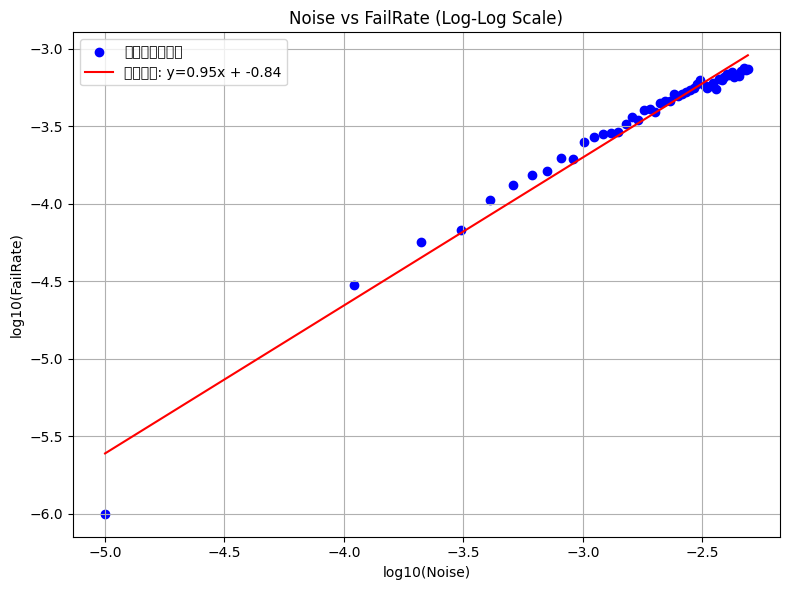

回帰直線の式: log10(FailRate) = 0.9548 * log10(Noise) + -0.8364
決定係数 (R^2): 0.9707


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# データを読み込む
# output.txt がスペース区切りで、最初の列が Noise、2 列目が FailRate と仮定
try:
    data = pd.read_csv('output.txt', sep='\s+', header=None, names=['Noise', 'FailRate'])
    print("データの読み込みに成功しました。")
except Exception as e:
    print(f"データの読み込み中にエラーが発生しました: {e}")
    exit()

# データの最初の数行を表示して確認
print("読み込んだデータの先頭:")
print(data.head())

# 数値型に変換（エラーがある場合は NaN にする）
data['Noise'] = pd.to_numeric(data['Noise'], errors='coerce')
data['FailRate'] = pd.to_numeric(data['FailRate'], errors='coerce')

# 変換できなかったデータの確認
if data['Noise'].isnull().any() or data['FailRate'].isnull().any():
    print("数値変換に失敗したデータが存在します。該当する行を除外します。")
    print(data[data.isnull().any(axis=1)])

# NaN を含む行を除外
data = data.dropna(subset=['Noise', 'FailRate'])

# FailRate が0でないデータのみを選択
filtered_data = data[data['FailRate'] > 0]

# Noise が0でないことも確認（念のため）
filtered_data = filtered_data[filtered_data['Noise'] > 0]

# フィルタリング後のデータ数を表示
print(f"フィルタリング後のデータ数: {len(filtered_data)}")

# 対数変換
log_noise = np.log10(filtered_data['Noise'])
log_failrate = np.log10(filtered_data['FailRate'])

# 線形回帰（対数スケールで）
slope, intercept, r_value, p_value, std_err = stats.linregress(log_noise, log_failrate)

# 回帰直線の計算
regression_line = slope * log_noise + intercept

# プロット
plt.figure(figsize=(8,6))
plt.scatter(log_noise, log_failrate, color='blue', label='データポイント')
plt.plot(log_noise, regression_line, color='red', label=f'回帰直線: y={slope:.2f}x + {intercept:.2f}')
plt.xlabel('log10(Noise)')
plt.ylabel('log10(FailRate)')
plt.title('Noise vs FailRate (Log-Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 回帰結果の表示
print(f"回帰直線の式: log10(FailRate) = {slope:.4f} * log10(Noise) + {intercept:.4f}")
print(f"決定係数 (R^2): {r_value**2:.4f}")
